# Mutliple multiplications - independence distributions

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from pathlib import Path
import pickle

from physics_mi.utils import set_all_seeds

RESULTS = Path("results")

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 689334534
set_all_seeds(seed)
print(seed)

2354766866


## Model

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Results

In [4]:
fps = list(RESULTS.glob("*.pkl"))

rows = []
for fp in tqdm(fps):
    with open(fp, "rb") as f:
        data = pickle.load(f)
    rows.append(data)

df = pd.DataFrame(rows)

df["valid_loss"] = df["valid_loss"].map(float)

  0%|          | 0/142 [00:00<?, ?it/s]

In [5]:
df.head()

,valid_loss,outputs,model,seed
0,0.000400,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(-0.1858), ...",1080586112
1,0.000664,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(0.0037), t...",825201060
2,0.000276,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(-0.4611), ...",500382378
3,0.000242,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(-0.2236), ...",340316710
4,0.000163,"{'layers.0.linear.weight': [[tensor(0.), tenso...","{'layers.0.linear.weight': [[tensor(0.2780), t...",337361766


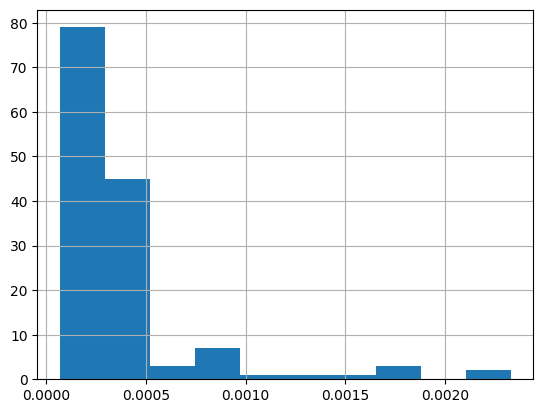

In [6]:
_ = df["valid_loss"].hist()

All of these seemed to train well.

## Introspection

In [7]:
N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)
pairs = pairs.repeat(2, axis=0).reshape(-1, 4)


def plot_node_activity(acts, eps=0.05):
    fig, axes = plt.subplots(4, 4, figsize=(12, 10))  # Increase the width to make space for the colorbar
    axes = axes.flatten()

    for i in range(acts.shape[1]):
        col = acts[:, i]
        activated_mask = acts[:, i].abs() > eps  # really trying to focus on the activated areas
        activated_mask = torch.ones(col.shape, dtype=bool)
        sc = axes[i].scatter(
            pairs[activated_mask, 0],
            pairs[activated_mask, 1],
            c=col[activated_mask],
            cmap="bwr",
            s=50,
            norm=plt.Normalize(vmin=-1, vmax=1),
        )

        axes[i].set_title(f"Node {i+1}")
        axes[i].set_xlabel("x1")
        axes[i].set_ylabel("x2")
        axes[i].set_aspect("equal")
        axes[i].set_xlim(-0.05, 1.05)
        axes[i].set_ylim(-0.05, 1.05)

    # Position the colorbar on the right of the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(sc, cax=cbar_ax)

    fig.suptitle("Activity of each node")
    fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots

Aggregate all the contributions:

In [8]:
ncss = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    lws = row["model"]["layers.1.linear.weight"]
    acts = row["outputs"]["layers.0.act"]
    ncs = acts[..., None] * lws.t()  # ncs = neuron contributions
    ncs = ncs.mean(0).numpy()
    ncss.append(ncs)

ncss = np.concatenate(ncss, axis=0)
ncss.shape

  0%|          | 0/142 [00:00<?, ?it/s]

(2272, 2)

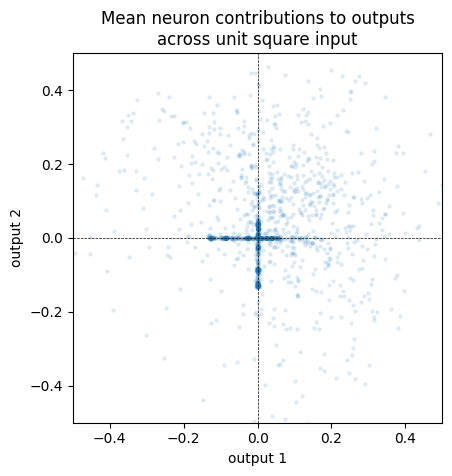

In [9]:
fig, ax = plt.subplots()

ax.scatter(*ncss.T, s=5, alpha=0.1)
ax.set_aspect("equal")
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.vlines(0, -0.5, 0.5, color="k", linestyles="--", lw=0.5)
ax.hlines(0, -0.5, 0.5, color="k", linestyles="--", lw=0.5)

ax.set_xlabel("output 1")
ax.set_ylabel("output 2")
_ = ax.set_title("Mean neuron contributions to outputs\nacross unit square input")

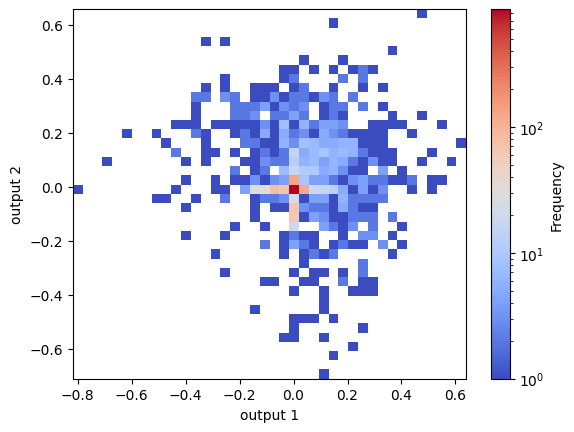

In [10]:
from matplotlib.colors import LogNorm

# Create the 2D histogram plot
fig, ax = plt.subplots()
h = ax.hist2d(*ncss.T, bins=(40, 40), cmap="coolwarm", norm=LogNorm())

cbar = plt.colorbar(h[3], ax=ax)
cbar.set_label("Frequency")

ax.set_aspect("equal")
ax.set_xlabel("output 1")
_ = ax.set_ylabel("output 2")

Let's see if we can zoom in a little on the centre:

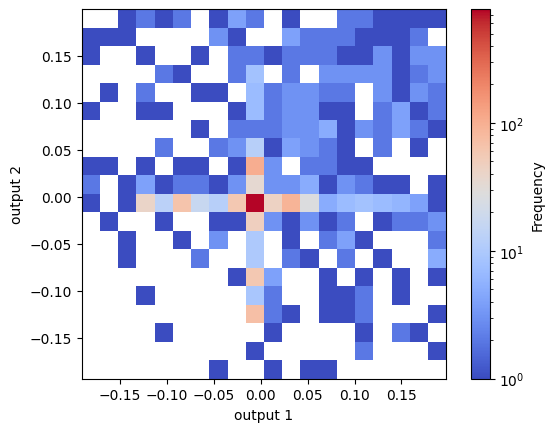

In [11]:
from matplotlib.colors import LogNorm

X = ncss.copy()
mask = (X < 0.2).all(1) & (X > -0.2).all(1)
X = X[mask]

# Create the 2D histogram plot
fig, ax = plt.subplots()
h = ax.hist2d(*X.T, bins=(20, 20), cmap="coolwarm", norm=LogNorm())

cbar = plt.colorbar(h[3], ax=ax)
cbar.set_label("Frequency")

ax.set_aspect("equal")
ax.set_xlabel("output 1")
_ = ax.set_ylabel("output 2")

Here it's easier to see a clear preference for orthogonal outputs although we'll definitely need to look into the large cloud of non-orthogonal outputs...

There's also some interesting structure on the orthogonal outputs where the preferred contributions seem to cluster at certain intervals 🤔

Let's see what proportion of outputs are roughly orthogonal.

First I need to remove the 0-valued constributions because these are going to throw off the angles.

In [12]:
ncss.shape, (ncss > 0).any(1).mean()

((2272, 2), 0.5999119718309859)

In [13]:
ncss = ncss[(ncss > 0).any(1)]
ncss.shape

(1363, 2)

In [14]:
angles = np.arctan2(ncss[:, 1], ncss[:, 0])

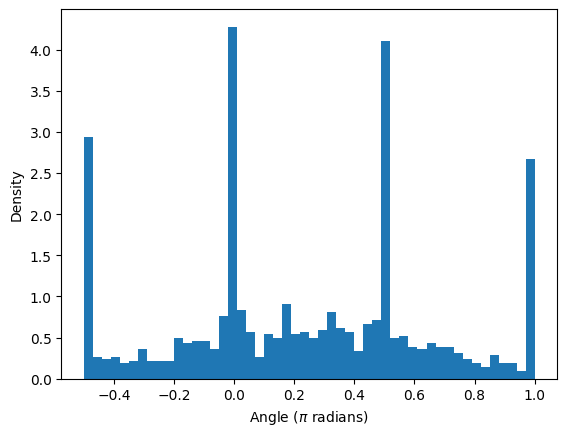

In [15]:
fig, ax = plt.subplots()

ax.hist(angles / np.pi, bins=50, density=True)
ax.set_ylabel("Density")
_ = ax.set_xlabel("Angle ($\pi$ radians)")

Should really be doing one of those nice rose plots here 🏵️

In [44]:
def get_hos(ncss):
    angles = np.arctan2(ncss[..., 1], ncss[..., 0])
    hos = np.abs(
        (np.mod(angles, np.pi / 2) - np.pi / 4) / (np.pi / 4)
    )  # I'm sure there's a neater way of doing this...
    return hos

In [45]:
hos = get_hos(ncss)

Now to sanity-check this score:

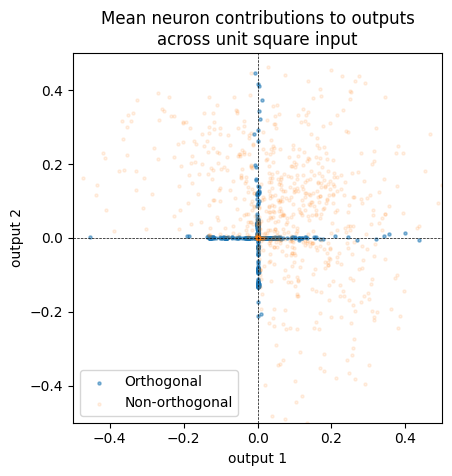

In [ ]:
fig, ax = plt.subplots()

ortho_mask = hos > 0.95

ax.scatter(*ncss[ortho_mask].T, s=5, alpha=0.5, label="Orthogonal")
ax.scatter(*ncss[~ortho_mask].T, s=5, alpha=0.1, label="Non-orthogonal")
ax.set_aspect("equal")
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.vlines(0, -0.5, 0.5, color="k", linestyles="--", lw=0.5)
ax.hlines(0, -0.5, 0.5, color="k", linestyles="--", lw=0.5)

ax.set_xlabel("output 1")
ax.set_ylabel("output 2")
ax.legend()
_ = ax.set_title("Mean neuron contributions to outputs\nacross unit square input")

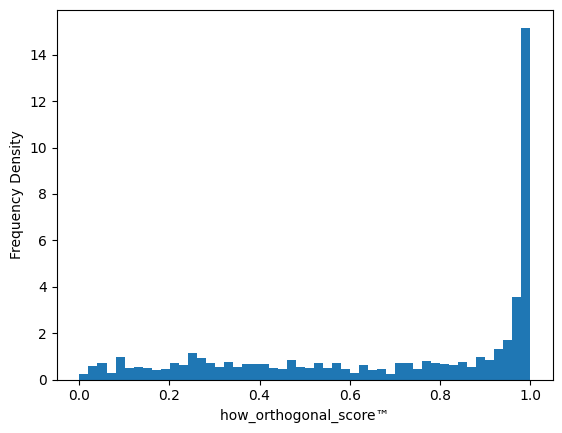

In [46]:
fig, ax = plt.subplots()

_ = ax.hist(hos, bins=50, density=True)
ax.set_ylabel("Frequency Density")
_ = ax.set_xlabel("how_orthogonal_score™️")

In [48]:
(hos > 0.95).mean()

0.39251650770359503

Ok so ~40% are within $\pm 5\%$ of being orthogonal. This still leaves a large number that aren't really orthogonal...

Maybe I can plot the `how_ortho_score` against magnitude of the neuron contribution and it might show that we're really not contributing much for the non-orthogonal contributions?

In [59]:
contrib_strength = np.linalg.norm(ncss, axis=1)
contrib_strength.shape

(1363,)

In [60]:
def bin_and_plot(x, y, num_bins):
    # 1. Define bin edges for the x data (how_ortho_score)
    bin_edges = np.linspace(x.min(), x.max(), num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 2 & 3. For each bin, calculate the mean and std of y (contrib_score) and the uncertainty
    means, stds, uncertainties = [], [], []
    for i in range(num_bins):
        mask = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
        means.append(y[mask].mean())
        stds.append(y[mask].std())
        uncertainties.append(stds[-1] / np.sqrt(mask.sum()))

    # 4. Plot the mean values with error bars
    fig, ax = plt.subplots()
    ax.errorbar(
        bin_centers,
        means,
        yerr=uncertainties,
        fmt="o-",
        capsize=5,
        color="#FFB6C1",
        ecolor="#DB7093",
        elinewidth=1.5,
        markersize=5,
    )

    # Aesthetic tweaks for a 'pastel and sexy' look
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title("Mean Contrib vs Ortho Score", fontsize=14)
    ax.set_xlabel("Ortho Score", fontsize=12)
    ax.set_ylabel("Mean Contrib", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()

In [61]:
def bin_and_plot_sum(x, y, num_bins):
    # 1. Define bin edges for the x data (how_ortho_score)
    bin_edges = np.linspace(x.min(), x.max(), num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 2 & 3. For each bin, calculate the mean and std of y (contrib_score) and the uncertainty
    proportions = []
    for i in range(num_bins):
        mask = (x >= bin_edges[i]) & (x < bin_edges[i + 1])
        proportions.append(y[mask].sum() / y.sum())

    # 4. Plot the mean values with error bars
    fig, ax = plt.subplots()
    ax.errorbar(
        bin_centers,
        proportions,
        fmt="o-",
        capsize=5,
        color="#FFB6C1",
        ecolor="#DB7093",
        elinewidth=1.5,
        markersize=5,
    )

    # Aesthetic tweaks for a 'pastel and sexy' look
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title("Total Contrib vs Ortho Score", fontsize=14)
    ax.set_xlabel("Ortho Score", fontsize=12)
    ax.set_ylabel("Total Contrib Proportion", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()

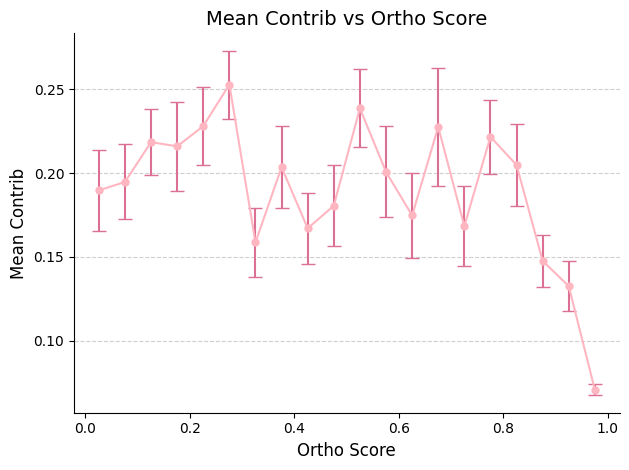

In [62]:
bin_and_plot(how_ortho_score, contrib_strength, num_bins=20)

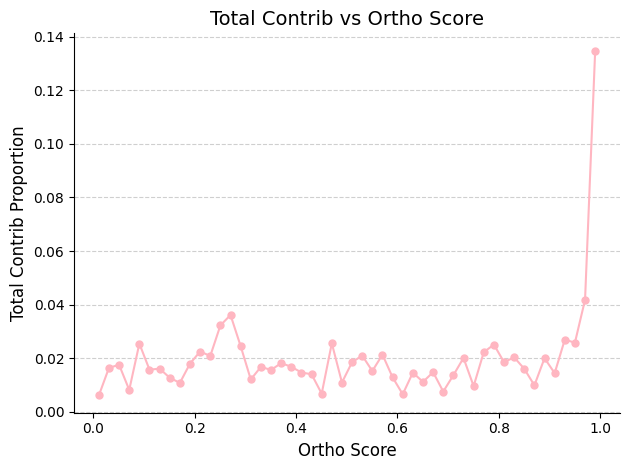

In [63]:
bin_and_plot_sum(how_ortho_score, contrib_strength, num_bins=50)

So this is telling us that the orthogonal components are contributing the most towards the final output, although each orthogonal neuron contributes less on average than the components that are shared between the outputs. To put it another way, this is a picture of most of the work towards the final output being distributed between a larger number of weakly contributing neurons that are _independent_ between the different tasks as well as a few neurons that firing more strongly but do not contribute so much towards the final result that are shared between the two tasks.

_Although_ I have to be careful with this interpretation because it doesn't take into account neurons that might cancel each other out.

### Cancellation

In [64]:
ncss = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    lws = row["model"]["layers.1.linear.weight"]
    acts = row["outputs"]["layers.0.act"]
    ncs = acts[..., None] * lws.t()  # ncs = neuron contributions
    ncs = ncs.numpy()
    ncss.append(ncs)

ncss = np.stack(ncss, axis=0)
ncss.shape

  0%|          | 0/142 [00:00<?, ?it/s]

(142, 25, 16, 2)

I need to remove the [0,0] vectors again which means I'll lose my nice array shape :(

In [106]:
examples = []
for ncs in ncss:
    keep_mask = ~(ncs.mean(0) == 0).all(-1)
    ncs = ncs[:, keep_mask]
    ncs = ncs.reshape(25, -1, 2)
    examples.append(ncs)

hos = [get_hos(ex) for ex in examples]

In [112]:
nonortho_contribs = []
ortho_contribs = []
for score, ncs in zip(hos, examples):
    ortho_mask = score > 0.95
    ortho_contrib = ncs[ortho_mask].sum(0)
    nonortho_contrib = ncs[~ortho_mask].sum(0)
    ortho_contribs.append(ortho_contrib)
    nonortho_contribs.append(nonortho_contrib)

nonortho_contribs = np.stack(nonortho_contribs)
ortho_contribs = np.stack(ortho_contribs)

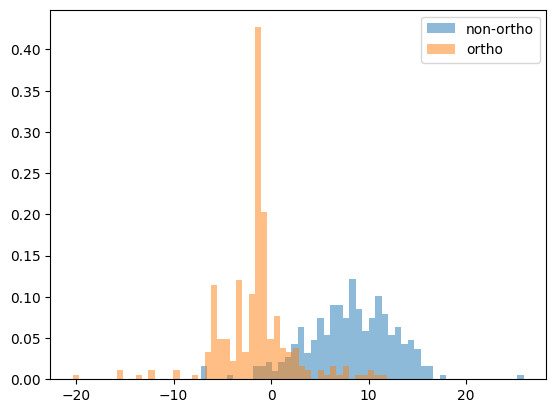

In [113]:
fig, ax = plt.subplots()

ax.hist(nonortho_contribs.flatten(), bins=50, density=True, alpha=0.5, label="non-ortho")
_ = ax.hist(ortho_contribs.flatten(), bins=50, density=True, alpha=0.5, label="ortho")

ax.legend()

Need to think about the BIASES.

I've been confusing myself a little here - time to pull it back and look at individual examples just to check that my metrics/understanding are all good 👍